# 3D Gaussian Splatting for Real-Time Radiance Field Rendering (SIGGRAPH 2023)

arXiv - https://arxiv.org/abs/2308.04079

## 0. What is 3D Gaussian Splatting?

In page 4 of the paper,

> *We Choose 3D Gaussians, which are differentiable and can be easily projected to 2D Splats allowing fast alpha-blending or rendering.*

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/overview.JPG" alt="Overview of 3D Gaussian Splatting">
</div>

## 1. Preprocess the Dataset

### 1.1 Download the NeRF-synthetic Dataset

> The paper uses 3 datasets, NeRF-synthetic dataset, Mip-NeRF 360 dataset, and Tanks&Templates dataset.

We will start with NeRF-synthetic dataset that are easy to access.

In [1]:
from pathlib import Path
import gdown

# Setup dataset folder
dataset_path = Path("datasets/")

# Check if the dataset folder exists, and if not, download the dataset.
if dataset_path.is_dir():
  print(f"[INFO] {dataset_path} already exists.")
else:
  print(f"[INFO] Cannot find {dataset_path}, creating the directory...")
  dataset_path.mkdir(parents=True, exist_ok=True)

[INFO] Cannot find datasets, creating the directory...


In [2]:
!gdown "https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g" -O "./datasets/nerf_synthetic.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g
From (redirected): https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g&confirm=t&uuid=8803e729-a791-43d5-828f-b781f090a493
To: /content/datasets/nerf_synthetic.zip
100% 1.27G/1.27G [00:10<00:00, 122MB/s]


In [3]:
import zipfile

# Unzip NeRF_Synthetic dataset
with zipfile.ZipFile(dataset_path / "nerf_synthetic.zip", "r") as zip_ref:
  print("[INFO] Unzipping nerf_synthetic dataset...")
  zip_ref.extractall(dataset_path)

# Delete existing compressed dataset file
!rm "./datasets/nerf_synthetic.zip"

[INFO] Unzipping nerf_synthetic dataset...


### 1.2 Explore the NeRF-synthetic dataset

Stats:
+ 8 Scenes -  ***(chair, drums, ficus, hotdog, lego, materials, mic, ship)***
+ 100 Training images
+ 100 Validation images
+ 200 Test images
+ Images are 800x800

Structure:
  * SCENE_NAME
    * train
      * r_num.png
    * val
      * r_num.png
    * test
      * r_num.png
      * r_num_depth_0000.png
      * r_num_normal_0000.png
    * transforms_train.json
    * transforms_val.json
    * transforms_test.json

Transform json details:
  * camera_angle_x: The FOV in x dimension
  * frames: List of dictionaries that contain the camera transform matrices for each image.

Random image path: datasets/nerf_synthetic/chair/test/r_5.png
Image Height * Width : 800 * 800


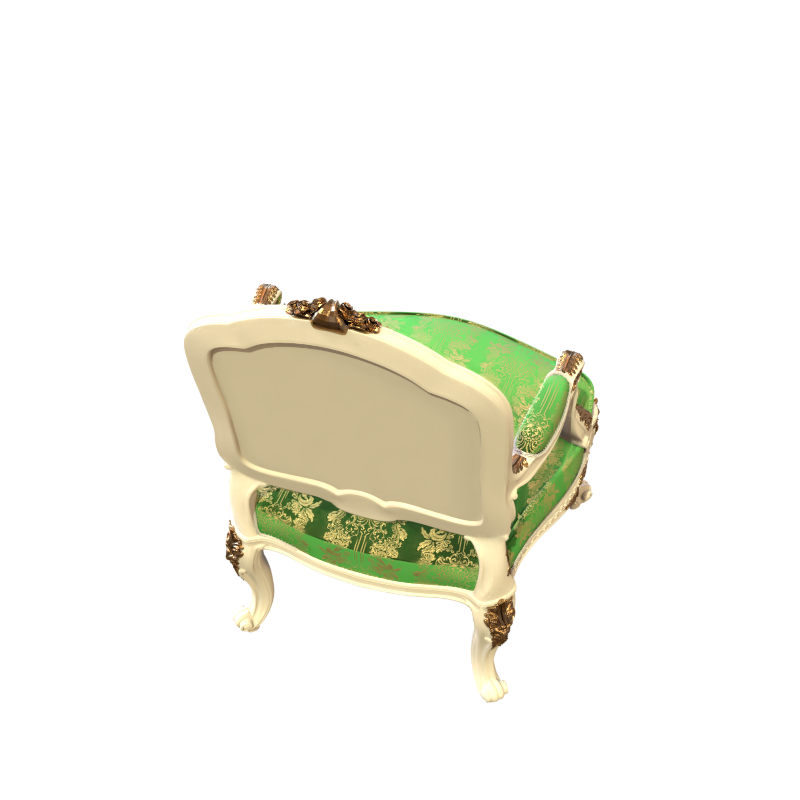

In [4]:
import random
from PIL import Image

# Get All Image Paths
nerf_synthetic_path = dataset_path / "nerf_synthetic"
image_path_list = list(nerf_synthetic_path.glob("*/*/*.png"))

# Get Random Image Path
random_image_path = random.choice(image_path_list)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Height * Width : {img.height} * {img.width}")
img

### 1.3 Make SfM (Structure-from-Motion) points from NeRF-synthetic dataset



In [5]:
!pip install pycolmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 46.8 MB/s eta 0:00:00


In [6]:
from pathlib import Path
import pycolmap
from pycolmap import logging
import shutil

def make_SfM_points(image_path: Path, category: str):
  """
  Args:
    image_path : pathlib.Path
    category : str - (e.g, chair, drums, ficus, hotdog, lego, materials, mic, ship)
  """
  output_path = Path("COLMAP/")
  category_path = output_path / category

  category_path.mkdir(parents=True, exist_ok=True)
  logging.set_log_destination(logging.INFO, output_path / "logs")

  database_path = category_path / "database.db"
  sfm_path = category_path / "sfm"

  print(f"[INFO] Processing category: {category}")
  if database_path.exists():
    database_path.unlink()

  pycolmap.extract_features(database_path, image_path)
  pycolmap.match_exhaustive(database_path)

  num_images = pycolmap.Database(database_path).num_images
  print(f"[INFO] Found {num_images} images in {category} dataset.")

  if sfm_path.exists():
    shutil.rmtree(sfm_path)
  sfm_path.mkdir(exist_ok=True)

  records = pycolmap.incremental_mapping(database_path, image_path, sfm_path)

  for idx, record in records.items():
    logging.info(f"#{idx} {record.summary}")

  print(f"[INFO] SfM completed for {category}.")

In [7]:
categories = ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]

for category in categories:
  image_path = nerf_synthetic_path / category / "train"
  make_SfM_points(image_path, category)

[INFO] Processing category: chair
[INFO] Found 100 images in chair dataset.
[INFO] SFM completed for chair.
[INFO] Processing category: drums
[INFO] Found 100 images in drums dataset.
[INFO] SFM completed for drums.
[INFO] Processing category: ficus
[INFO] Found 100 images in ficus dataset.
[INFO] SFM completed for ficus.
[INFO] Processing category: hotdog
[INFO] Found 100 images in hotdog dataset.
[INFO] SFM completed for hotdog.
[INFO] Processing category: lego
[INFO] Found 100 images in lego dataset.
[INFO] SFM completed for lego.
[INFO] Processing category: materials
[INFO] Found 100 images in materials dataset.
[INFO] SFM completed for materials.
[INFO] Processing category: mic
[INFO] Found 100 images in mic dataset.
[INFO] SFM completed for mic.
[INFO] Processing category: ship
[INFO] Found 100 images in ship dataset.
[INFO] SFM completed for ship.


In [8]:
from google.colab import files
import shutil

# 1. Compress COLMAP folders
shutil.make_archive("NeRF_synthetic_SfM_points", "zip", "/content/COLMAP")

# 2. Download the compressed files
files.download("NeRF_synthetic_SfM_points.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Note:** The above process takes a long time, so you can skip it.

In [ ]:
# !wget https://huggingface.co/datasets/pleasure97/NeRF_synthetic_SfM_Points.zip
# !unzip NeRF_synthetic_SfM_Points.zip

### 1.4 Visualize SfM points from NeRF-synthetic dataset

In [9]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninst

In [32]:
from pathlib import Path
import numpy as np
import open3d as o3d
import plotly.graph_objects as go

def visualize_SfM_points(sfm_path: Path):
  """ Visualize the SfM points using Open3D.

  Args:
    sfm_path: Path to the SfM folder containing the COLMAP outputs.
  """
  print(f"[INFO] Loading SfM data from: {sfm_path}")
  category = sfm_path.parent.stem
  reconstruction = pycolmap.Reconstruction(sfm_path)

  # Collect 3D points
  points = []
  colors = []

  for point3D in reconstruction.points3D.values():
    points.append(point3D.xyz)
    colors.append(point3D.color / 255.)

  points = np.array(points)
  colors = np.array(colors)

  print(f"[INFO] {category} points shape : {points.shape} | colors shape : {colors.shape}")

  # Create open3d point cloud
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(points)
  pcd.colors = o3d.utility.Vector3dVector(colors)

  # Visualize the point cloud
  print(f"[INFO] Visualizing {category} {len(points)} points...")

  fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2],
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
  )
  fig.show()

In [36]:
import random
selected_category = random.choice(categories)
sfm_path = Path("COLMAP/") / selected_category / "sfm/0"

visualize_SfM_points(sfm_path)

[INFO] Loading SfM data from: COLMAP/chair/sfm/0
[INFO] sfm points shape : (13061, 3) | colors shape : (13061, 3)
[INFO] Visualizing sfm 13061 points...


## 2. Initialization

### 2.1 Create a set of 3D Gaussians

In page 4 of the paper,

> $$ G(x)=e^{-\frac{1}{2}(x)^T \Sigma^{-1}(x)}$$

> $$ \Sigma^{\prime}=J W \Sigma W^T J^T $$

> $$ \Sigma=R S S^T R^T$$

## References

https://xoft.tistory.com/44

https://xoft.tistory.com/51